# The Influenza H1N1 2009 Pandemic in Sweden

## 1.1 Epidemic on a known graph

In this first section, it was asked to simulate an epidemic on a symmetric k-regular graph created with the *networkx* in-built function *circulant_graph*.The *simulate* function takes as input the starting graph and the given parameters and it returns the average number of susceptibles, infected, recovered and new infected individuals per week. This was accomplished by tracking with *numpy* arrays, for each simulation, for each week the total number of nodes that are susceptible, infected, recovered or the new infected. After generating the initial node configuration by sampling a given number of nodes and assigning them the infected status, it is necessary to store both the old and updated node configuration in a *numpy* array. Each node can have 3 states (SIR). This initial simulation will serve as the basic framework for the entire homework.  
The graph must have 500 nodes, with an initial configuration of 10 infected ones. The parameters are as follow: $k=4$, $\beta=0.3$, $\rho=0.7$, the number of simulations is set to 100 with 15 weeks. The parameter $\beta$ indicates the probability that the infection spreads from and infected node to a susceptible one when they are connected by a link, while $\rho$ is the probability that an infected individual will recover. Both are referred to a unit time step (a week in this case).  
In the pictures below we can see the trend of the average newly infected individuals each week together with the average number of infected individuals each week.  
This other plot depics the entire SIR epidemics with the different average node statuses per week.

To highlight the importance of the parameters, it is possible to notice how the plot changes by putting $\beta=0.4$ and $\rho=0.1$. Even though the new infected rate per week has a similar pattern, the number of infected individuals grows much rapidly while that of the susceptible one decreases much faster.

## 1.2 Generate a random graph

In this section it was asked to generate a random graph according to the *preferential attachment model*. This was accomplished with the *generate_rnd_graph_pa* function which takes as input the average degree $k$ and the maximal number of time steps. At first a complete graph with $k+1$ nodes is generated, then we sample $c=k/2$ nodes according to their distribution and we attatch a new node to them with undirected links. This is repeated untill we reach the maximal number of time steps (or when we have a graph with a desired number of nodes). 
The parameter c is computed dynamicallay in order to adjust to the odd case as specified in the exercise: in a certain iteration $t$, if $t$ is even we take the *floor* of $k/2$ and the *ceiling* otherwise.

## 2 Simulate a pandemic without vaccination

The objective of this section was to simulate a pandemic wihtout vaccination on a random graph with preferential attatchment with an average degree $k=6$. The other parameters are as in the previous sections.  
The first plot shows the average number of newly infected individuals each week together with the average number of infected individuals each week.  
This other plot depics the entire SIR epidemics with the different average node statuses per week.

## 3 Simulate a pandemic with vaccination

In this section it was asked to simulate a pandemic with vaccination. This was accomplished with the *simulate_vaccination* function. Its inner workings are similar to that of the *simulate* function, but in this case we would like to track the vaccinated individuals. The percentage of individuals to vaccinate each week was obtained from the given weekly cumulative percentage of vaccinated people and, on top of the node states of the SIR model (susceptible, infected ad removed), a new node state was added in order to flag an individual as vaccinated in the node configuration (recovered people can be vaccinated). I also made possible to have vaccinated individuals in the first week (useful for the next sections) by sampling them at the beginning in the same fashion I also sampled the infected indviduals.  
In the following figures we can see that, with respect to the previous section, the average number of newly infected individuals per week is lower and the pandemic is dying earlier.

## 4 The H1N1 pandemic in Sweden 2009

In this section we had to estimate the social structure of the Swedish population and the disease-spread parameters during the H1N1 pandemic. This was accomplished by using 3 new nested functions.  
The *search_best_params* function will perform a grid search with a given set of values for $\beta$, $\rho$ and $k$ by invoking the previously mentioned *simulate_vaccination* and *generate_rnd_graph_pa* functions and it will return the best combination in terms of RMSE. Each parameter needs to live in a certain range ($\beta$, $\rho$ must be between 0 and 1 since they are probabilities and $k$ sould be greater than 1) and this is ensured by the function *necessary_conditions*.  
The function *update_parameters* will receive the result of the previous computations and if the RMSE is better it will update the parameters $\beta$, $\rho$ and $k$ before invoking again the *search_best_params* function. If the result is worse or if the parameters $\beta$, $\rho$ and $k$ are the same in 2 consecutive iterations this function return the current best configuration.  
The outermost function *algorithm* changes the $\Delta\beta$, $\Delta\rho$ and $\Delta k$ and it will return the best overall RMSE with its corresponding parameters.  

I started with the following parameters:
$$
\beta=  \quad \rho=  \quad k=  \quad \Delta\beta=  \quad \Delta\rho=  \quad \Delta k=
$$

The best results are as follow:
$$
RMSE=  \quad \beta=  \quad \rho=  \quad k=
$$

From the figures below we can see that 


# Code for the assignment

In [42]:
import networkx as nx
import numpy as np
import scipy as sp
from random import choice, sample
import sys
import math
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

## 1 Epidemic on a known graph

### Problem 1.1

In [43]:
n_nodes = 500
k_regular = nx.circulant_graph(n_nodes, [1,2])
#nx.draw_circular(k_regular, with_labels=True)

In [44]:
def simulate(graph, n_nodes, initial_infected, n_simulations, n_weeks, beta, ro):

  # Vectors for storing a particular type of node:
  # i^th row corresponds to the i^th simulation,
  # j^th column corresponds to the j^th week
  susceptible_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  recovered_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  new_infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)

  # 10 initial infected nodes at weak 0 of each simulation
  infected_nodes[:, 0] = initial_infected
  new_infected_nodes[:, 0] = initial_infected
  susceptible_nodes[:, 0] = n_nodes - initial_infected
  #recovered_nodes[:, 0] = 0

  for simulation in range(n_simulations):
    # The node configuration has a column for the old and the updated configuration
    nodes_configuration = np.zeros((n_nodes, 2), dtype=int)
    #initial_infected_nodes = sample(graph.nodes(), initial_infected)
    initial_infected_nodes = np.random.choice(graph.nodes, size=(initial_infected,) ,replace=False)

    for node in initial_infected_nodes:
      nodes_configuration[node, 0] = 1

    for week in range(n_weeks):
      weekly_susceptible_nodes = 0
      weekly_infected_nodes = 0
      weekly_recovered_nodes = 0
      weekly_new_infected_nodes = 0


      for node in graph.nodes:
        if nodes_configuration[node, 0] == 0:
          m = 0
          # Count neighbours that are I
          for neighbour in graph.neighbors(node):
            if nodes_configuration[neighbour, 0] == 1:
              m+=1
          if np.random.rand() < (1-beta)**m:
            nodes_configuration[node, 1] = 0
            weekly_susceptible_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1
            weekly_new_infected_nodes += 1


          """prob_not_I = (1-beta)**m
          probs = [prob_not_I, 1-prob_not_I]
          nodes_configuration[node, 1] = np.random.choice([0, 1], size=1, p=probs, replace=False)
          #print(np.random.choice([0, 1], size=1, p=probs, replace=False))
          if nodes_configuration[node, 1] == 1:
            weekly_infected_nodes += 1
            weekly_new_infected_nodes += 1
          else:
            weekly_susceptible_nodes += 1"""

        elif nodes_configuration[node, 0] == 1:

          if np.random.rand() < ro:
            nodes_configuration[node, 1] = 2
            weekly_recovered_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1

          """probs = [1-ro, ro]
          nodes_configuration[node, 1] = np.random.choice([1, 2], size=1, p=probs, replace=False)          
          if nodes_configuration[node, 1] == 2:
            weekly_recovered_nodes += 1
          else:
            weekly_infected_nodes += 1"""

        else:
          nodes_configuration[node, 1] = 2
          weekly_recovered_nodes += 1
      #print(weekly_susceptible_nodes, weekly_infected_nodes, weekly_recovered_nodes, weekly_new_infected_nodes)

      infected_nodes[simulation, week] = weekly_infected_nodes
      susceptible_nodes[simulation, week] = weekly_susceptible_nodes
      recovered_nodes[simulation, week] = weekly_recovered_nodes
      new_infected_nodes[simulation, week] = weekly_new_infected_nodes
      nodes_configuration[:, 0] = nodes_configuration[:, 1]
      #print(infected_nodes)
      #print(infected_nodes.shape)
      #sys.exit()

  infected_nodes_avg = np.mean(infected_nodes, axis=0)
  susceptible_nodes_avg = np.mean(susceptible_nodes, axis=0)
  recovered_nodes_avg = np.mean(recovered_nodes, axis=0)
  new_infected_nodes_avg = np.mean(new_infected_nodes, axis=0) 

  return infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg

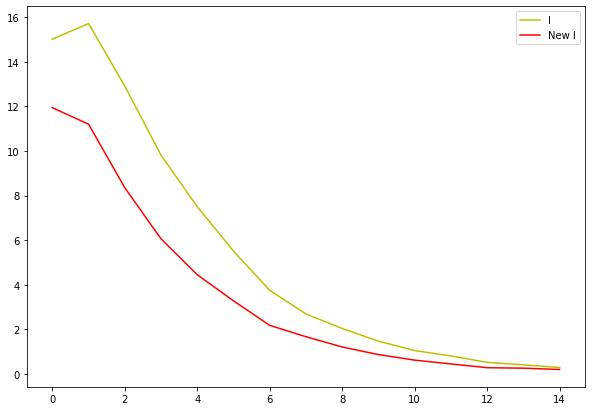

In [45]:
np.random.seed(0)
infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg = simulate(k_regular, n_nodes, 10, 100, 15, 0.3, 0.7)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(infected_nodes_avg, 'y', label='I')
ax.plot(new_infected_nodes_avg, 'r', label='New I')
ax.legend(loc='best')
plt.savefig("I_newI_ex1_1.png")
plt.show()

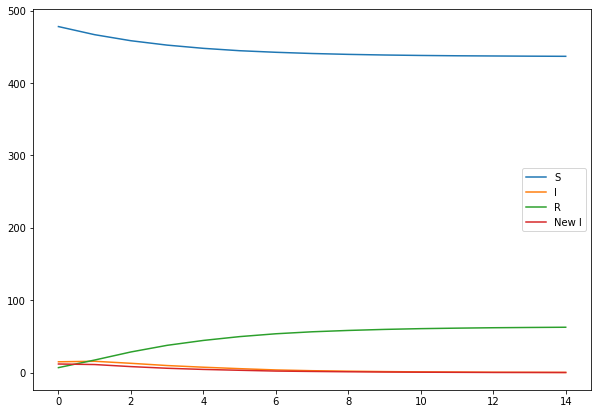

In [46]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(susceptible_nodes_avg, label='S')
ax.plot(infected_nodes_avg, label='I')
ax.plot(recovered_nodes_avg, label='R')
ax.plot(new_infected_nodes_avg, label='New I')
ax.legend(loc='best')
plt.savefig("SIR_ex1_1.png")
plt.show()

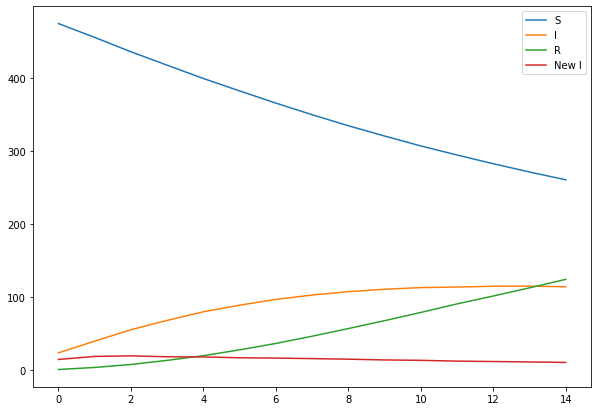

In [47]:
np.random.seed(0)
infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg = simulate(k_regular, n_nodes, 10, 100, 15, 0.4, 0.1)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(susceptible_nodes_avg, label='S')
ax.plot(infected_nodes_avg, label='I')
ax.plot(recovered_nodes_avg, label='R')
ax.plot(new_infected_nodes_avg, label='New I')
ax.legend(loc='best')
plt.savefig("SIR_ex1_1_change.png")
plt.show()

### Problem 1.2

In [48]:
def generate_rnd_graph_pa(avg_deg, max_time):

  initial_nodes = avg_deg + 1
  rnd_graph_pa = nx.complete_graph(initial_nodes)  
  #nx.draw_circular(rnd_graph_pa, with_labels=True)

  for t in range(initial_nodes, max_time):

    # compute dinamically c in order to adjust for odd case:
    # take floor when t is even
    # take ceil when t is odd
    if t % 2 == 0:
      c = int(math.floor(avg_deg/2))
    else:
      c = int(math.ceil(avg_deg/2))
    #print(c)
    
    # compute deg distribution at time t-1
    degrees = np.array([d for n, d in rnd_graph_pa.degree()])
    deg_distr = degrees/sum(degrees)
    neighbors = np.random.choice(np.array(rnd_graph_pa.nodes()), p=deg_distr, size=c, replace=False)
    
    # add new node with edges
    node = max(rnd_graph_pa.nodes())+1
    rnd_graph_pa.add_node(node)
    for neigh in neighbors:
        rnd_graph_pa.add_edge(node, neigh) 
  
  return rnd_graph_pa


In [49]:
# checking if it works
k = 10
rnd_graph_pa = generate_rnd_graph_pa(k, 900)
#nx.draw_circular(rnd_graph_pa, with_labels=True)
degrees = np.array([d for n, d in rnd_graph_pa.degree()])
#print(degrees)
print("Average degree: ", np.mean(degrees))
print("Number of nodes: ", rnd_graph_pa.number_of_nodes())

Average degree:  10.0
Number of nodes:  900


In [50]:
# checking if it works also with odd numbers
k = 11
rnd_graph_pa = generate_rnd_graph_pa(k, 900)
#nx.draw_circular(rnd_graph_pa, with_labels=True)
degrees = np.array([d for n, d in rnd_graph_pa.degree()])
#print(degrees)
print("Average degree: ", np.mean(degrees))
print("Number of nodes: ", rnd_graph_pa.number_of_nodes())

Average degree:  11.0
Number of nodes:  900


## 2 Simulate a pandemic without vaccination

### Problem 2

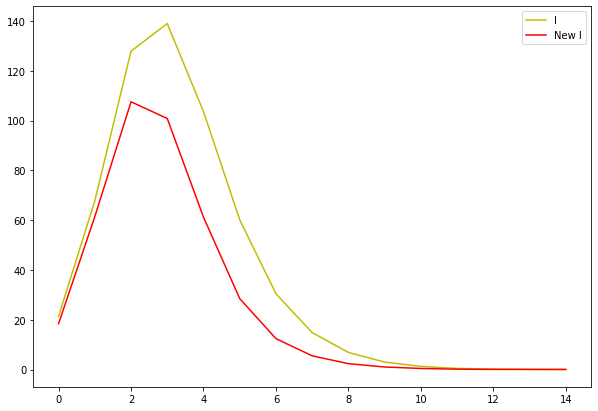

In [51]:
np.random.seed(0)
k = 6
max_nodes = 500
n_weeks = 15
beta = 0.3
ro = 0.7
initial_infected = 10
n_iterations = 100

rnd_graph_pa = generate_rnd_graph_pa(k, max_nodes)

infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg = simulate(rnd_graph_pa, max_nodes, initial_infected, n_iterations, n_weeks, beta, ro)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(infected_nodes_avg, 'y', label='I')
ax.plot(new_infected_nodes_avg, 'r', label='New I')
ax.legend(loc='best')
plt.savefig("I_newI_ex2.png")
plt.show()

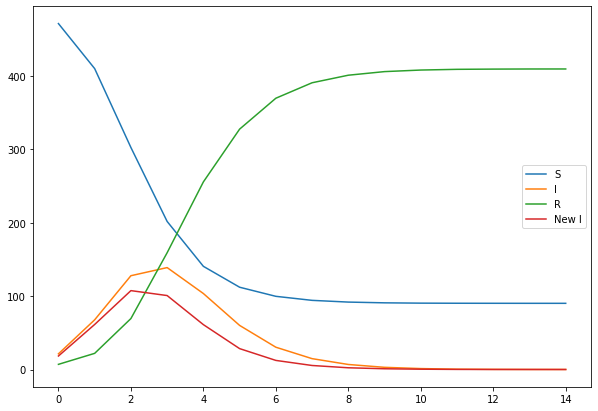

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(susceptible_nodes_avg, label='S')
ax.plot(infected_nodes_avg, label='I')
ax.plot(recovered_nodes_avg, label='R')
ax.plot(new_infected_nodes_avg, label='New I')
ax.legend(loc='best')
plt.savefig('SIR_ex2.png')
plt.show()

## 3 Simulate a pandemic with vaccination

### Problem 3

In [53]:
def simulate_vaccination(graph, n_nodes, initial_infected, n_simulations, n_weeks, beta, ro, vacc_t):

  # Vectors for storing a particular type of node:
  # i^th row corresponds to the i^th simulation,
  # j^th column corresponds to the j^th week
  susceptible_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  recovered_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  new_infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)

  # 10 initial infected nodes at weak 0 of each simulation
  infected_nodes[:, 0] = initial_infected
  new_infected_nodes[:, 0] = initial_infected
  susceptible_nodes[:, 0] = n_nodes - initial_infected
  #recovered_nodes[:, 0] = 0

  vacc_perc = n_nodes * np.array(vacc_t) / 100
  #print(vacc_perc)
  vacc_perc = vacc_perc.astype(int)
  #print(vacc_perc)
  weekly_vacc_perc = vacc_perc.copy()
  weekly_vacc_perc[1:] = weekly_vacc_perc[1:]-weekly_vacc_perc[:-1]

  for simulation in range(n_simulations):
    # The node configuration has a column for the old and the updated configuration
    nodes_configuration = np.zeros((n_nodes, 2), dtype=int)
    # modifying this for the next execise in order to have more than 0 vaxx nodes at week 0
    initial_infected_vacc_nodes = np.random.choice(graph.nodes, size=(initial_infected + weekly_vacc_perc[0], ), replace=False)
    initial_infected_nodes = initial_infected_vacc_nodes[:initial_infected]
    initial_vacc_nodes = initial_infected_vacc_nodes[initial_infected: ]

    for node in initial_infected_nodes:
      nodes_configuration[node, 0] = 1
    for node in initial_vacc_nodes:
      nodes_configuration[node, 0] = 3

    for week in range(n_weeks):
      weekly_susceptible_nodes = 0
      weekly_infected_nodes = 0
      weekly_recovered_nodes = 0
      weekly_new_infected_nodes = 0


      if weekly_vacc_perc[week] != 0:
        vaccinated_nodes = np.random.choice(np.argwhere(nodes_configuration[:, 0]!=3).flatten(), size=weekly_vacc_perc[week], replace=False)
        for node in vaccinated_nodes:
          nodes_configuration[node, 0] = 3

      for node in graph.nodes:
        if nodes_configuration[node, 0] == 0:
          m = 0
          # Count neighbours that are I
          for neighbour in graph.neighbors(node):
            if nodes_configuration[neighbour, 0] == 1:
              m+=1
          if np.random.rand() < (1-beta)**m:
            nodes_configuration[node, 1] = 0
            weekly_susceptible_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1
            weekly_new_infected_nodes += 1


        elif nodes_configuration[node, 0] == 1:

          if np.random.rand() < ro:
            nodes_configuration[node, 1] = 2
            weekly_recovered_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1

        elif nodes_configuration[node, 0] == 2:
          nodes_configuration[node, 1] = 2
          weekly_recovered_nodes += 1
        
        else:
          nodes_configuration[node, 1] = 3

      infected_nodes[simulation, week] = weekly_infected_nodes
      susceptible_nodes[simulation, week] = weekly_susceptible_nodes
      recovered_nodes[simulation, week] = weekly_recovered_nodes
      new_infected_nodes[simulation, week] = weekly_new_infected_nodes
      nodes_configuration[:, 0] = nodes_configuration[:, 1]

  infected_nodes_avg = np.mean(infected_nodes, axis=0)
  susceptible_nodes_avg = np.mean(susceptible_nodes, axis=0)
  recovered_nodes_avg = np.mean(recovered_nodes, axis=0)
  new_infected_nodes_avg = np.mean(new_infected_nodes, axis=0) 
  

  return infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg, vacc_perc, weekly_vacc_perc

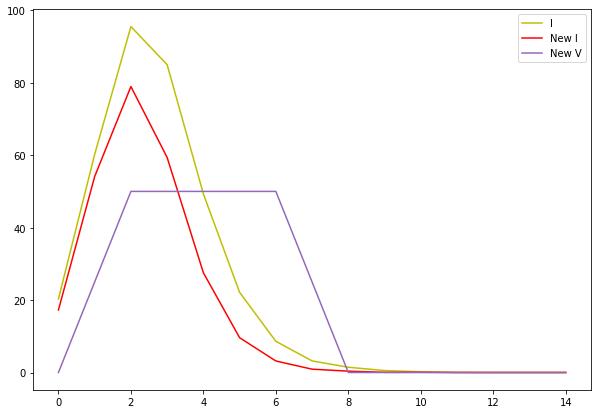

In [54]:
np.random.seed(0)
k = 6
max_nodes = 500
n_weeks = 15
beta = 0.3
ro = 0.7
initial_infected = 10
n_iterations = 100
vacc_t = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

rnd_graph_pa = generate_rnd_graph_pa(k, max_nodes)

infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg, vacc_perc, weekly_vacc_perc = simulate_vaccination(rnd_graph_pa, max_nodes, initial_infected, n_iterations, n_weeks, beta, ro, vacc_t)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(infected_nodes_avg, 'y', label='I')
ax.plot(new_infected_nodes_avg, 'r', label='New I')
ax.plot(weekly_vacc_perc, 'tab:purple', label='New V')
ax.legend(loc='best')
plt.savefig("I_newI_vacc_ex3.png")
plt.show()

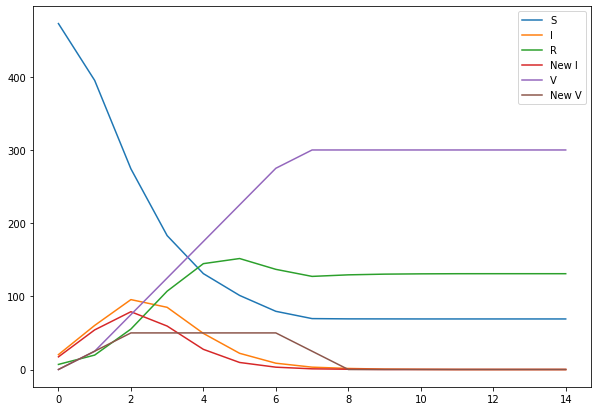

In [55]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(susceptible_nodes_avg, label='S')
ax.plot(infected_nodes_avg, label='I')
ax.plot(recovered_nodes_avg, label='R')
ax.plot(new_infected_nodes_avg, label='New I')
ax.plot(vacc_perc, label='V')
ax.plot(weekly_vacc_perc, label='New V')
ax.legend(loc='best')
plt.savefig("SIR_ex3.png")
plt.show()

## 4 The H1N1 pandemic in Sweden 2009

### Problem 4

In [29]:
def RMSE(infected_nodes_avg, infected_ground_truth):
  #print(infected_nodes_avg)
  #print(infected_ground_truth)
  return np.sqrt(1/infected_nodes_avg.shape[0] * np.sum((infected_nodes_avg - infected_ground_truth)**2))

def necessary_conditions(beta_set, ro_set, k_set):
  for i in range(3):
    # check if the values of beta are between 0 and 1
    if beta_set[i] < 0:
      beta_set[i] = 0.0
    elif beta_set[i] > 1:
      beta_set[i] = 1.0
    
    # do the same for ro
    if ro_set[i] < 0:
      ro_set[i] = 0.0
    elif ro_set[i] > 1:
      ro_set[i] = 1.0
    
    # avg deg at least 2
    if k_set[i] <=1:
      k_set[i] = 2 

def search_best_params(k0, beta0, ro0, d_k, d_beta, d_ro, n_nodes, n_weeks, n_iterations, vacc_t, infected_ground_truth):
  # construct the 3 parameters spaces
  beta_set = np.array([beta0 - d_beta, beta0, beta0 + d_beta])
  ro_set = np.array([ro0 - d_ro, ro0, ro0 + d_ro])
  k_set = np.array([k0 - d_k, k0, k0 + d_k])
  
  necessary_conditions(beta_set, ro_set, k_set)

  # we have 3 parameters with 3 possible values each,
  # we will have to compute 3x3x3 times the result and
  # choose the best one for updating the parameters
  initial_infected = infected_ground_truth[0]
  best_res = {'beta':-1, 'ro':-1, 'k':-1, 'rmse':None}
  best_epidemic = None

  for beta in beta_set:
    for ro in ro_set:
      for k in k_set:
        rnd_graph_pa = generate_rnd_graph_pa(k, n_nodes)
        epidemic = simulate_vaccination(rnd_graph_pa, n_nodes, initial_infected, n_iterations, n_weeks, beta, ro, vacc_t)
        rmse = RMSE(epidemic[0], infected_ground_truth)
        #print(beta, ro, k)
        #print(rmse)
        #print()
        #print(epidemic[0], rmse)
        if best_res['rmse'] is None or rmse < best_res['rmse']:
          best_res['beta'] = beta
          best_res['ro'] = ro
          best_res['k'] = k
          best_res['rmse'] = rmse
          best_epidemic = epidemic
        #print()
  #print(best_res)      
  return best_res, best_epidemic[0], best_epidemic[1], best_epidemic[2], best_epidemic[3], best_epidemic[4], best_epidemic[5]
  


In [30]:
def update_parameters(k0, beta0, ro0, d_k, d_beta, d_ro, n_nodes, n_weeks, n_iterations, vacc_t, infected_ground_truth):

  stop_sim = False
  global_res = None

  #print(d_k, d_beta, d_ro)

  while stop_sim is False:
    res = search_best_params(k0, beta0, ro0, d_k, d_beta, d_ro, n_nodes, n_weeks, n_iterations, vacc_t, infected_ground_truth)

    rmse = res[0]['rmse']
    beta = res[0]['beta']
    ro = res[0]['ro']
    k = res[0]['k']

    print(res[0])
    #print(res[1])

    # initial value
    if global_res is None:
      global_res = res

    #print(beta0, ro0, k0, beta, ro, k)
    #print(rmse, global_res[0]['rmse'])
  
    # if same stop
    if (beta, ro, k) == (beta0, ro0, k0):
      # if same and rmse lower save new value
      if rmse < global_res[0]['rmse']:
        global_res = res
      stop_sim = True
    
    # if not improving stop and parameters are different
    elif rmse > global_res[0]['rmse']:
      stop_sim = True

    # update initial parameters
    else:
      global_res = res
      k0 = k
      beta0 = beta
      ro0 = ro

  print()
  return global_res

In [31]:
def algorithm(k0, beta0, ro0, n_nodes, n_weeks, n_iterations, vacc_t, infected_ground_truth):
  delta_beta_set = [0.2, 0.1, 0.05, 0.025]
  delta_ro_set = [0.2, 0.1, 0.05, 0.025]
  delta_k_set = [3, 2, 1, 1]
  best_res = None

  for i in range(len(delta_beta_set)):
    d_k = delta_k_set[i]
    d_beta = delta_beta_set[i]
    d_ro = delta_ro_set[i]

    print(f"k0={k0}, beta0={beta0}, ro0={ro0}, delta_k={d_k}, delta_beta={d_beta}, delta_ro={d_ro}")
    res = update_parameters(k0, beta0, ro0, d_k, d_beta, d_ro, n_nodes, n_weeks, n_iterations, vacc_t, infected_ground_truth)

    #beta0 = res[0]['beta']
    #k0 = res[0]['k']
    #ro0 = res[0]['ro']

    #print(res[1])
    if best_res is None or res[0]['rmse'] < best_res[0]['rmse']:
      best_res = res

    #print(res[0]['rmse'], best_res[0]['rmse'])

  return best_res


In [39]:
np.random.seed(0)
vacc_t = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
infected_ground_truth = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
n_nodes = 934
n_weeks = len(vacc_t)
n_iterations = 10
k0 = 10
beta0 = 0.3
ro0 = 0.5

best_res, best_infected_nodes, best_susceptible_nodes, best_recovered_nodes, best_new_infected_nodes, best_vacc_perc, best_weekly_vacc_perc = algorithm(k0, beta0, ro0, n_nodes, n_weeks, n_iterations, vacc_t, infected_ground_truth)

k0=10, beta0=0.3, ro0=0.5, delta_k=3, delta_beta=0.2, delta_ro=0.2
{'beta': 0.09999999999999998, 'ro': 0.5, 'k': 13, 'rmse': 6.9589869952457875}
{'beta': 0.09999999999999998, 'ro': 0.7, 'k': 16, 'rmse': 5.859500831982192}
{'beta': 0.09999999999999998, 'ro': 0.49999999999999994, 'k': 13, 'rmse': 6.0903612372337985}

k0=10, beta0=0.3, ro0=0.5, delta_k=2, delta_beta=0.1, delta_ro=0.1
{'beta': 0.19999999999999998, 'ro': 0.6, 'k': 8, 'rmse': 5.225837253493454}
{'beta': 0.19999999999999998, 'ro': 0.5, 'k': 6, 'rmse': 7.152490824880519}

k0=10, beta0=0.3, ro0=0.5, delta_k=1, delta_beta=0.05, delta_ro=0.05
{'beta': 0.25, 'ro': 0.5, 'k': 10, 'rmse': 21.196815798605225}
{'beta': 0.2, 'ro': 0.55, 'k': 10, 'rmse': 10.554264540933206}
{'beta': 0.15000000000000002, 'ro': 0.5, 'k': 9, 'rmse': 6.4331660168225095}
{'beta': 0.15000000000000002, 'ro': 0.5, 'k': 8, 'rmse': 6.644405541506328}

k0=10, beta0=0.3, ro0=0.5, delta_k=1, delta_beta=0.025, delta_ro=0.025
{'beta': 0.27499999999999997, 'ro': 0.5, 'k

Best rmse: {'beta': 0.19999999999999998, 'ro': 0.6, 'k': 8, 'rmse': 5.225837253493454}


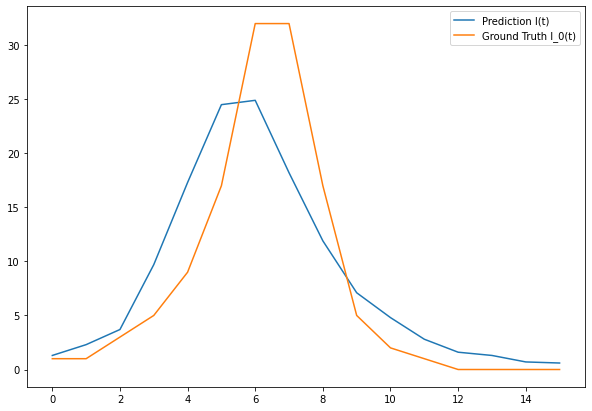

In [40]:
print(f"Best rmse: {best_res}")
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(best_infected_nodes, label='Prediction I(t)')
ax.plot(infected_ground_truth, label='Ground Truth I_0(t)')
ax.legend(loc='best')
plt.savefig('pred_vs_GT.png')
plt.show()

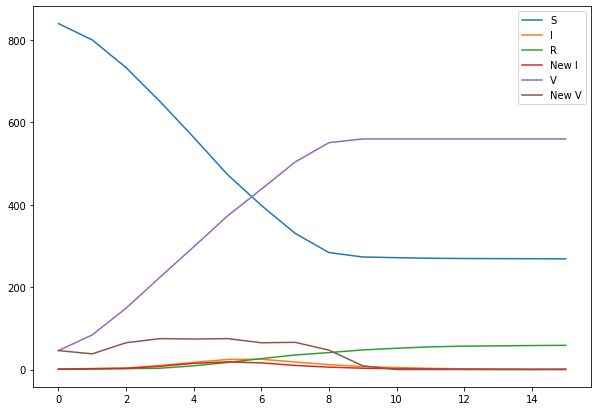

In [41]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(best_susceptible_nodes, label='S')
ax.plot(best_infected_nodes, label='I')
ax.plot(best_recovered_nodes, label='R')
ax.plot(best_new_infected_nodes, label='New I')
ax.plot(best_vacc_perc, label='V')
ax.plot(best_weekly_vacc_perc, label='New V')
ax.legend(loc='best')
plt.savefig('SIR_ex4.png')
plt.show()

## 5 Challenge (optional)

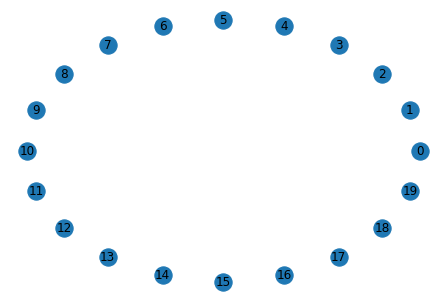

In [ ]:
n_nodes = 20
k_regular = nx.circulant_graph(n_nodes, [0])
nx.draw_circular(k_regular, with_labels=True)
l = np.random.binomial(n_nodes*4/2, 0.8, 1)
for i in range(int(l)):
  res = np.random.choice(np.array(k_regular.nodes()), size=2, replace=False)
  a = res[0]
  b = res[1]
  if not k_regular.has_edge(a, b):
    k_regular.add_edge(a, b)

#nx.draw_circular(k_regular, with_labels=True)

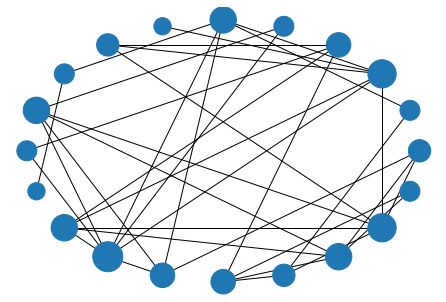

In [ ]:
d = dict(k_regular.degree)

#nx.draw(k_regular, nodelist=d.keys(), node_size=[v *100 for v in d.values()])
nx.draw_circular(k_regular, nodelist=d.keys(), node_size=[v *100 for v in d.values()])
plt.show()

In [ ]:
d

{0: 5,
 1: 4,
 2: 8,
 3: 6,
 4: 4,
 5: 7,
 6: 3,
 7: 5,
 8: 4,
 9: 7,
 10: 4,
 11: 3,
 12: 7,
 13: 9,
 14: 6,
 15: 6,
 16: 5,
 17: 7,
 18: 8,
 19: 4}